# HOMEWORK 3: Designing Closed Loop Systems

**COMMENTS**
9/10. You clearly understand the material, and had good answers. But you submitted a notebook with a code error.

This homework involves designing a closed loop system with a PID controller.

In [ ]:
!pip -q install controlSBML
import controlSBML as ctl
import control
from controlSBML.util import makeSimulationTimes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import tellurium as te
import sympy
print("controlSBML version: " + ctl.__version__)

     |████████████████████████████████| 398 kB 6.3 MB/s 
     |████████████████████████████████| 8.8 MB 37.7 MB/s 
     |████████████████████████████████| 154 kB 12.0 MB/s 
     |████████████████████████████████| 438 kB 48.9 MB/s 
     |████████████████████████████████| 6.8 MB 33.0 MB/s 
     |████████████████████████████████| 121 kB 43.1 MB/s 
     |████████████████████████████████| 342 kB 53.3 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 428 kB 67.0 MB/s 
     |████████████████████████████████| 561 kB 44.2 MB/s 
     |████████████████████████████████| 80 kB 7.6 MB/s 
     |████████████████████████████████| 54 kB 1.6 MB/s 
     |████████████████████████████████| 130 kB 70.0 MB/s 
     |████████████████████████████████| 133 kB 49.6 MB/s 
     |████████████████████████████████| 250 kB 52.8 MB/s 
     |████████████████████████████████| 103 kB 49.7 MB/s 
     |████████████████████████████████| 843 kB 43.4 MB/s 
     |███████████████

In [ ]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)

In [ ]:
# Use the local file if it's available
BIOMD823 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

**Transfer Functions**
\begin{eqnarray}
H_{RY}(s) & = & \frac{Y(s)}{R(s)} & = & \frac{C(s) G(s)}{1 + C(s) G(s) F(s)} \\
H_{RE}(s) & = & \frac{E(s)}{R(s)} & = & \frac{1}{1 + C(s) G(s) F(s)} \\
H_{NY}(s) & = & \frac{Y(s)}{N(s)} & = & -\frac{ F(s)}{1 + C(s) G(s) F(s)} \\
H_{DY}(s) & = & \frac{Y(s)}{D(s)} & = & \frac{ C(s)}{1 + C(s) G(s) F(s)} \\
\end{eqnarray}

In this homework, you will design a closed loop system for controlling pDEPTOR in the mTOR system as modelled in BioModels 823.
Use pAkt as the control input.
1. **Build**. (4 pt) Implement the function ``evaluateDesign`` that evaluates the control design of
a closed loop system for mTOR.
The evaluation is in the form of a plot of the step response of the system
to a change in the reference input.
The plot should include the reference input along with the pAkt and pDEPTOR
values for the closed loop mTOR system. The function has as inputs the design parameters kp, ki, kd.
1. **Design**. (2 pt) Use ``evaluateDesign`` to design a system that has no bias for a unit step response in the reference and settles within 10 seconds.
1. **Analysis**. (3 pt) Construct the transfer function
for mTOR from pAkt to pDEPTOR
and the transfer function $H_{NY} (s)$ for the design parameters you used in (2)
(Obtain the Jacobian at time 1 from the open loop mTOR system.)
Use these transfer functions to answer the following questions about how the closed loop system should behave *in theory*.
   1. Why are large control inputs required to control the mTOR system?
   1. Why are there no long term oscillations in the closed loop system?
   1. How will a step increase in noise affect the output of the closed loop system?
1. **Discussion**. (1 pt) Plot the values of pAkt for the closed loop system you designed in (2).
What issues do you see with using this closed loop system in practice?

# Helpers

In [ ]:
def plotTFs(Gs, kp=0, ki=0, kd=0, times=TIMES, ylim=None, title=None, is_plot=True):
    """
    Constructs the transfer functions for the proportional controller, and filter.
    Calculates the transfer functions HRYs, HREs, HNYs, HDYs and plots them.
    
    Parameters
    ----------
    Gs: control.TransferFunction
    kp: float
    ki: float
    kd: float
    times: list-float
    ylim: (float, float)
        limits of y-values
    title: str
    
    Returns
    -------
    dct
        key: name of transfer function
        value: control.TransferFunction
    """
    Cs = control.TransferFunction([kp], [1]) + control.TransferFunction([ki], [1, 0])  \
        + control.TransferFunction([kd, 0], [1])
    Fs = 1
    denom = 1 + Cs*Gs*Fs
    # Construct the transfer functions
    tf_dct = {
        "HRYs": Cs*Gs/denom,
        "HREs": 1/denom,
        "HNYs": -Fs/denom,
        "HDYs": Cs/denom,
    }
    # Construct the plots
    _, ax = plt.subplots(1)
    for tf in tf_dct.values():
        result = control.forced_response(tf, T=times, U=1)
        plt.plot(result.t.flatten(), result.y.flatten())
    # Refine plots
    plt.legend(list(tf_dct.keys()))
    xmax = max(result.t.flatten())
    plt.plot([0, xmax], [0, 0], linestyle="--", color="black")
    plt.plot([0, xmax], [1, 1], linestyle="--", color="grey")
    plt.ylim([-5, 5])
    title = "kp=%2.2f ki=%2.2f kd=%2.2f" % (kp, ki, kd)
    plt.title(title)
    if not is_plot:
        plt.close()
    return tf_dct
    
# Tests
Gs = control.TransferFunction([2], [1, 3])
dct = plotTFs(Gs, kp=10, ylim=[0, 3], title="Example", is_plot=False)
assert(len(dct) == 4)
assert("TransferFunction" in str(type(dct["HRYs"])))
print("OK!")

OK!


In [ ]:
def makeHRY(model, input_name, output_name, time=0, kp=0, ki=0, kd=0):
    """
    Calculates the transfer function from the reference input to the output.
    
    Parameters
    ----------
    model: str
    input_name: str
    output_name: str
    time: float
    kp: float
    ki: float
    kd: float
    
    Returns
    -------
    control.TransferFunction
    """
    ctlsb = ctl.ControlSBML(model, input_names=[input_name], output_names=[output_name])
    Gs = ctlsb.makeTransferFunction(time=time)
    dct = plotTFs(Gs, kp=kp, ki=ki, kd=kd, is_plot=False)
    return dct["HRYs"]
    
    
# TESTS
tf = makeHRY(BIOMD823, "pAkt", "pDEPTOR", kp=0)
assert(tf.dcgain() == 0)
print("OK!")

OK!


# Q1. Build

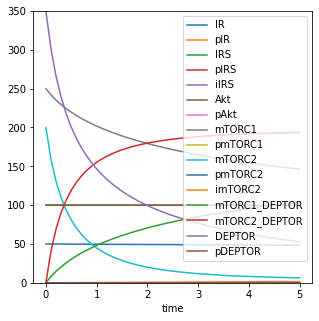

In [ ]:
ctlsb = ctl.ControlSBML(BIOMD823)
ctlsb.plotTrueModel(figsize=(5,5))

Include controller and mTOR pathway itself. No filter, disturbance, or noise. 

In [ ]:
def evaluateDesign(kp=0, ki=0, kd=0, is_plot=True):
    """
    Run the testbed and plot the results.
    
    Parameters
    ---------
    kp: float
    ki: float
    kd: float
    is_plot: bool
    
    Results
    -------
    closed_loop: control.InterconnectedSystem
    """
    #Get model
    model=BIOMD823
    # Construct elements of the closed loop system
    factory = ctl.IOSystemFactory()
    
    # Create the elements of the feedback loop
    input_name = "pAkt"
    output_name = "pDEPTOR"
    ctlsb = ctl.ControlSBML(BIOMD823, input_names=[input_name], output_names=[output_name])
    system = ctlsb.makeNonlinearIOSystem("system") # C(s)
    controller = factory.makePIDController("controller", kp=kp, ki=ki, kd=kd) #G(s)
    sum_R_S = factory.makeAdder("sum_R_S")

    # Create the closed loop system
    system_in = "system.%s" % input_name
    system_out = "system.%s" % output_name
    closed_loop = control.interconnect(
      [ system, controller, sum_R_S ], 
      connections=[
        ['controller.in', 'sum_R_S.out'],    # e(t)
        [system_in,   'controller.out'],   # u(t)
        ['sum_R_S.in1', "-" + system_out]
      ],
      inplist=["sum_R_S.in2"],
      outlist=["sum_R_S.in2", system_in, system_out],
    )

    X0 = ctl.makeStateVector(closed_loop)
    times = ctl.makeSimulationTimes(start_time=0, end_time=10, points_per_time=10)
    # Need the initial state
    result = control.input_output_response(closed_loop, T=times, U=1, X0=X0)
    plt.plot(result.t, result.outputs[0].flatten())
    plt.plot(result.t, result.outputs[1].flatten())
    plt.plot(result.t, result.outputs[2].flatten())

    plt.ylim([0, 20])
    legends = ["input", "pAkt", "pDEPTOR"]
    plt.legend(legends)
    if not is_plot:
        plt.close()
    #
    return closed_loop

# Tests
interconnect_sys = evaluateDesign(is_plot=False)
assert("Interconnect" in str(type(interconnect_sys)))
print("OK!")

OK!


# Q2. Design

**COMMENTS**

evaluateDesign has keyword parameters, but you're calling it using positional arguments. Although python supports this, doing so can cause errors if the order of the positional parameters is changed.

You found a design but I was hoping that you'd provide a narrative as well as to how you got here. However, this was not explicitly requested in the question, and so no points off.

You had good answers to the questions, but you had a code cell with an error in it. This would be like submitting an essay with spelling mistakes. I took off 1 point.

<InterconnectedSystem:sys[48]:['u[0]']->['y[0]', 'y[1]', 'y[2]']>

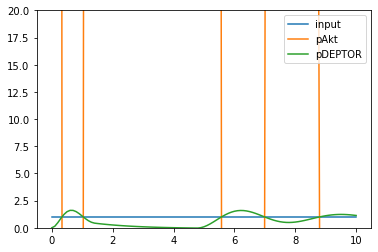

In [ ]:
evaluateDesign(1200, 0,0)

# Q3. Analyze

In [ ]:
# Create transfer function of system
tf = makeHRY(BIOMD823, "pAkt", "pDEPTOR", time=1, kp=1200, ki=0, kd=0)
tf

TransferFunction(array([-1.06581410e-011,  3.47222222e+001,  5.72873170e+002,
        3.53540099e+003,  1.02940945e+004,  1.51439319e+004,
        1.24296202e+004,  5.97631024e+003,  1.68525557e+003,
        2.67140570e+002,  2.22778860e+001,  1.04649083e+000,
        2.89191985e-002,  4.67762656e-004,  4.10538027e-006,
        1.51201814e-008,  2.59915451e-022,  1.99277394e-038,
       -1.84118616e-054, -4.12777091e-073,  1.00596731e-088,
       -3.45523287e-105,  7.17796417e-124, -8.91956646e-140,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), array([ 1.00000000e+000,  2.30701720e+001,  2.48390616e+002,
        1.59500969e+003,  6.26887138e+003,  1.45346308e+004,
        1.91637968e+004,  1.48365497e+004,  6.89306793e+003,
        1.90286225e+003,  2.97765162e+002,  2.46765553e+001,
        1.15531089e+000,  3.18634065e-002,  5.14728255e-004,
        4.51361859e-006,  1.66131904e-008,  2.60148735e-022,
     

In [ ]:
#Find DC gain of system
tf.dcgain()

nan

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/matfuncs.py:709: LinAlgWarning:

Ill-conditioned matrix (rcond=5.85673e-18): result may not be accurate.



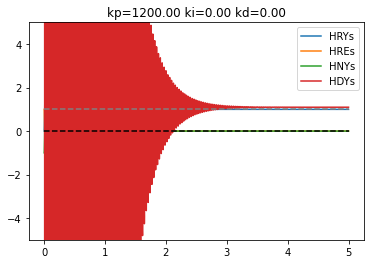

In [ ]:
#Plot transfer function 
tf_PLOT = plotTFs(tf,kp = 1200, ki = 0, kd = 0, times = TIMES, ylim= None, title = None, is_plot = True)

In [ ]:
# Plot noise transfer function
Cs = control.TransferFunction([kp], [1200]) + control.TransferFunction([ki], [1, 0])  \
        + control.TransferFunction([kd, 0], [1])
Fs = 1
denom = 1 + Cs*Gs*Fs
HNYs = -Fs/denom

result = control.forced_response(HNYs, T=times, U=1)
plt.plot(result.t.flatten(), result.y.flatten())
plt.title("HNYs transfer function plot")

NameError: ignored

**COMMENT**
This calculation is not central to your conclusions, but you should never submit code that doesn't run. I took off 1 point.

In [ ]:
# Get the Jacobian at time 1
JAC_TIME = 1
JACOBIAN = ctlsb.getJacobian(JAC_TIME)
JACOBIAN

1. Why are large control inputs required to control the mTOR system?

Large control inputs are required because the original DC gain of the system at low kp values is close to 0(shown below), meaning the input of pAkt barely has any impact on the output. However,pAkt and pDEPTOR are connected as shown in the biomodel, so there is some transfer of input to output. However, it seems that most of pAkt is converted to other products that lie outside of our closed loop, and so we need to input very large amounts of pAkt in order to estalish any kind of predictable control over pDEPTOR which lies downstream of our input past a few other reactions.  

In [ ]:
# The dc gain of the system at low kp value
tf_analyzedcgain = makeHRY(BIOMD823, "pAkt", "pDEPTOR", time=1, kp=1, ki=0, kd=0)
tf_analyzedcgain.dcgain()

2. Why are there no long term oscillations in the closed loop system?


In [ ]:
POLES_HRYs = tf.pole()
POLES_HRYs

There are no long term oscillations in the closed loop system because most of the poles of the transfer function are real. Those poles that have imaginary components have real components that are many orders of magnitude higher than their imaginary components. Since we can think of these poles as decaying exponentials in the time domain, the real components will contribute for much longer than the imaginary components, which is why oscillations dampen later in time.   

3. How will a step increase in noise affect the output of the closed loop system?


In [ ]:
HNYs.dcgain()

The output of the closed loop system will not be affected by a step increase in noise because the dc gain of the $H_{NY}$ transfer function is 0, meaning the noise has no effect on the output.  

# Q4. Discussion

Discussion. (1 pt) Plot the values of pAkt for the closed loop system you designed in (2). What issues do you see with using this closed loop system in practice?

In [ ]:
#Get model
model=BIOMD823
# Construct elements of the closed loop system
factory = ctl.IOSystemFactory()

# Create the elements of the feedback loop
input_name = "pAkt"
output_name = "pDEPTOR"
ctlsb = ctl.ControlSBML(BIOMD823, input_names=[input_name], output_names=[output_name])
system = ctlsb.makeNonlinearIOSystem("system") # C(s)
controller = factory.makePIDController("controller", kp=1200, ki=0, kd=0) #G(s)
sum_R_S = factory.makeAdder("sum_R_S")

# Create the closed loop system
system_in = "system.%s" % input_name
system_out = "system.%s" % output_name
closed_loop = control.interconnect(
[ system, controller, sum_R_S ], 
connections=[
['controller.in', 'sum_R_S.out'],    # e(t)
[system_in,   'controller.out'],   # u(t)
['sum_R_S.in1', "-" + system_out]
],
inplist=["sum_R_S.in2"],
outlist=[system_in],
)

X0 = ctl.makeStateVector(closed_loop)
times = ctl.makeSimulationTimes(start_time=0, end_time=10, points_per_time=10)
# Need the initial state
result = control.input_output_response(closed_loop, T=times, U=1, X0=X0)


plt.plot(result.t, result.outputs.flatten())
plt.ylim([-1000, 1200])
legends = ["pAkt"]
plt.legend(legends)
plt.title("Looking at just the pAkt values")

Using this closed loop system in practice would require way too much reagent. I think it would be very wasteful to use this much pAkt to try and control pDEPTOR, leading to higher costs and higher waste for the reaction. Also, introducing this much pAkt to control pDEPTOR could lead to unwanted changes in any of the other reactions within the total network. So while we may control pDEPTOR using huge amounts of pAkt, we could inadvertently make other reactions go wild.   